In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
import joblib
import matplotlib.pyplot as plt

In [ ]:
def create_time_lagged_features(df, target_col, hours_ahead=6):
    """
    Create time-shifted features for prediction
    """
    df = df.sort_values('date')
    
    # Create lagged features 
    for col in df.select_dtypes(include=[np.number]).columns:
        if col not in ['hour', 'month', 'day', 'day_of_week', 'longitude', 'latitude', 'departures', 'STL1_GDS0_DBLY']:
            df[f'{col}_lag1'] = df[col].shift(1)
            df[f'{col}_lag3'] = df[col].shift(3)
            df[f'{col}_lag6'] = df[col].shift(6)
            df[f'{col}_lag12'] = df[col].shift(12)
    
    # Create target variable
    df['target'] = df[target_col].shift(-hours_ahead)
    df = df[~df['target'].isnull()]
    return df

In [ ]:
def preprocess_data(df, era5=False, hours_ahead=6):
    """
    Preprocess the weather data for model training with time-shifted features
    """
    # Convert date to useful features
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek

    # Handle missing values
    for col in ['low_availability', 'high_availability', 'departures', 'complete']:
        df[col] = df[col].fillna(0)

    # Select relevant features
    base_features = [
        'longitude', 'latitude', 'hour', 'month', 'day', 'day_of_week',
        'STL1_GDS0_DBLY', '2T_GDS0_SFC', 'low_availability', 'high_availability',
        'complete', '2D_GDS0_SFC', 'STL2_GDS0_DBLY', 'STL3_GDS0_DBLY', 
        'SKT_GDS0_SFC', 'STL4_GDS0_DBLY', 'population', 'departures'
    ]

    # Remove features not available in ERA5 dataset
    if era5:
        base_features = [f for f in base_features if f not in 
                        ['departures', 'population', 'low_availability', 
                         'high_availability', 'complete']]
    
    # Create time-lagged features
    df = create_time_lagged_features(df[base_features + ['date']], 'STL1_GDS0_DBLY', hours_ahead)   
    df = df.drop(columns=['date', 'STL1_GDS0_DBLY'])
    
    return df

In [ ]:
class WeatherEnsemble(BaseEstimator, RegressorMixin):
    """
    Stacking ensemble for weather prediction that combines multiple models
    """
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        
        # Base models
        self.model1 = MLPRegressor(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            max_iter=20,
            early_stopping=True,
            verbose=False,
            random_state=42
        )
        
        # Good for capturing non-linear relationships
        self.model2 = RandomForestRegressor(
            n_estimators=20,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        )
        
        # Good for time series prediction
        self.model3 = GradientBoostingRegressor(
            n_estimators=20,
            learning_rate=0.1,
            max_depth=10,
            random_state=42
        )
        
        # Meta-learner to optimally combine the predictions from our three base models
        self.meta_learner = LassoCV(cv=3)
        
        self.base_models = [self.model1, self.model2, self.model3]
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        """
        Train the ensemble on the given data
        """
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Train base models
        print("Training base models...")
        for i, model in enumerate(self.base_models, 1):
            print(f"Training model {i}...")
            model.fit(X_scaled, y)
        
        # Generate predictions for meta-learner
        meta_features = np.column_stack([
            model.predict(X_scaled) for model in self.base_models
        ])
        
        # Train meta-learner
        print("Training meta-learner...")
        self.meta_learner.fit(meta_features, y)
        return self
    
    def predict(self, X):
        """
        Generate predictions using the ensemble
        """
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        # Generate base model predictions
        meta_features = np.column_stack([
            model.predict(X_scaled) for model in self.base_models
        ])
        
        # Generate final predictions using meta-learner
        return self.meta_learner.predict(meta_features)

    def get_meta_learner_weights(self):
        """
        Get the weights assigned to each base model by the meta-learner
        """
        model_names = ['MLP', 'Random Forest', 'Gradient Boosting']
        weights = self.meta_learner.coef_
        
        for name, weight in zip(model_names, weights):
            print(f"{name} weight: {weight:.3f}")
    
    def save(self, filename):
        """Save the ensemble model"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved ensemble model"""
        return joblib.load(filename)
    

    def viz_feature_importances(self, X_train):
        """
        Visualize feature importances for the Random Forest model
        """
        rf_model = self.base_models[1]
        feature_importances = rf_model.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)
        feature_importance_df.head(10).plot(x='feature', y='importance', kind='barh')
        plt.show()


In [ ]:
def evaluate_model(model, X, y, set_name=""):
    """
    Evaluate model performance with multiple metrics
    """
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = 1 - (((y - predictions) ** 2).sum() / ((y - y.mean()) ** 2).sum())
    
    print(f'{set_name} Results:')
    print(f'R² Score: {r2:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {np.sqrt(mse):.4f}\n')
    
    return predictions

In [ ]:
def evaluate_time_windows(df, model, max_hours=48, step_hours=6, era5=False, plot=True):
    results = []
    windows = range(step_hours, max_hours + step_hours, step_hours)
    
    for hours_ahead in windows:
        # Preprocess data for this time window
        df_window = preprocess_data(df.copy(), era5=era5, hours_ahead=hours_ahead)
        
        # Split features and target
        y_window = df_window['target']
        X_window = df_window.drop(columns=['target'])
        
        # Use same train/test split ratio as main model
        train_size = int(len(X_window) * 0.85)
        X_test = X_window[train_size:].bfill().ffill()
        y_test = y_window[train_size:]
        
        # Generate predictions
        predictions = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = 1 - (((y_test - predictions) ** 2).sum() / 
                  ((y_test - y_test.mean()) ** 2).sum())
        
        results.append({
            'hours_ahead': hours_ahead,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        })
    
    results_df = pd.DataFrame(results)
    
    if plot:
        plt.figure(figsize=(8, 4))
        
        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(results_df['hours_ahead'], results_df['rmse'], 
                marker='o', linestyle='-', linewidth=2)
        plt.title('RMSE vs Prediction Window')
        plt.xlabel('Hours Ahead')
        plt.ylabel('RMSE (°C)')
        plt.grid(True, alpha=0.3)
        
        # Plot R² score
        plt.subplot(1, 2, 2)
        plt.plot(results_df['hours_ahead'], results_df['r2'], 
                marker='o', linestyle='-', linewidth=2, color='green')
        plt.title('R² Score vs Prediction Window')
        plt.xlabel('Hours Ahead')
        plt.ylabel('R² Score')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Average RMSE: {results_df['rmse'].mean():.3f}°C")
        print(f"RMSE Range: {results_df['rmse'].min():.3f}°C - {results_df['rmse'].max():.3f}°C")
        print(f"Average R² Score: {results_df['r2'].mean():.3f}")
        
    return results_df

Running for ERA5: True
Training base models...
Training model 1...


c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Training model 2...
Training model 3...
Training meta-learner...
Ensemble Model Evaluation:
Training Results:
R² Score: 0.2782
MSE: 48.0412
MAE: 5.4669
RMSE: 6.9312

Test Results:
R² Score: -0.1534
MSE: 65.9583
MAE: 6.2172
RMSE: 8.1215

MLP weight: -0.251
Random Forest weight: -1.602
Gradient Boosting weight: 3.320


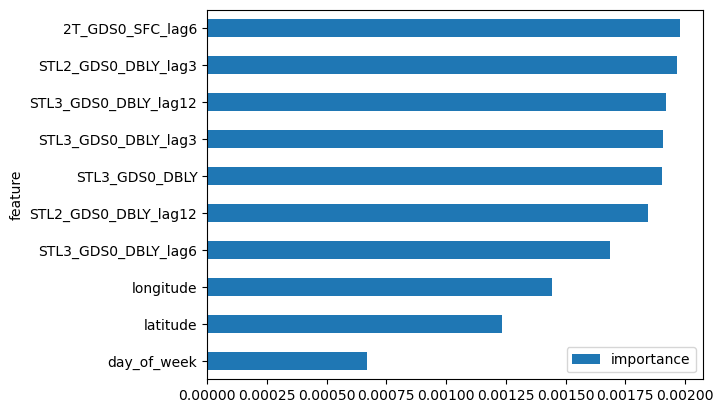

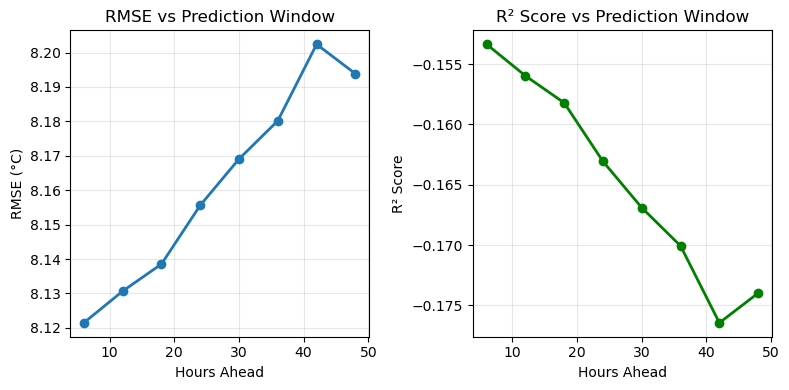


Summary Statistics:
Average RMSE: 8.161°C
RMSE Range: 8.121°C - 8.202°C
Average R² Score: -0.165
Running for ERA5: False
Training base models...
Training model 1...
Training model 2...
Training model 3...
Training meta-learner...
Ensemble Model Evaluation:
Training Results:
R² Score: 0.2790
MSE: 47.9839
MAE: 5.4629
RMSE: 6.9270

Test Results:
R² Score: -0.1256
MSE: 64.3721
MAE: 6.1470
RMSE: 8.0232

MLP weight: -0.126
Random Forest weight: -1.755
Gradient Boosting weight: 3.325


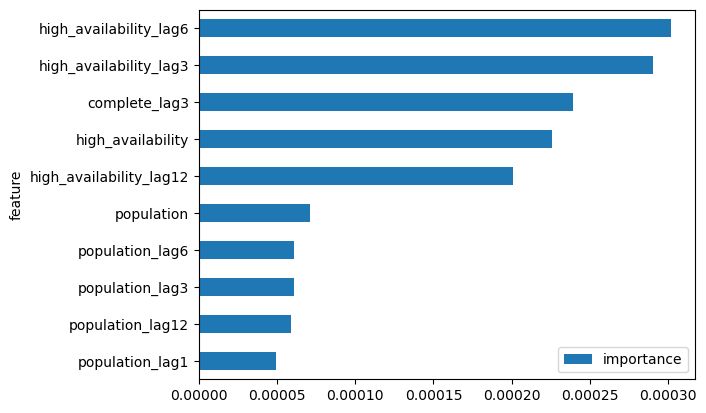

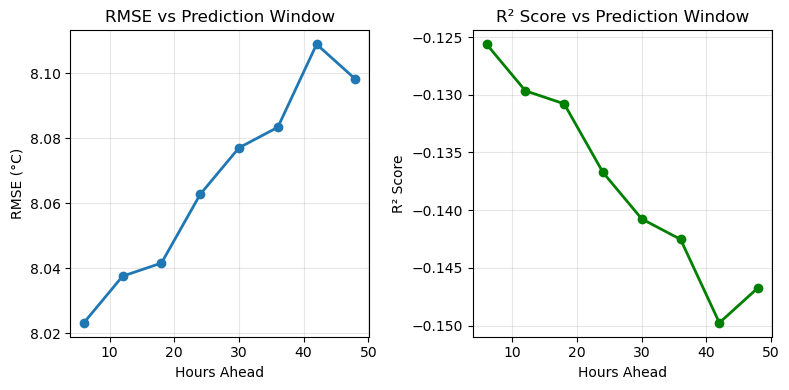


Summary Statistics:
Average RMSE: 8.067°C
RMSE Range: 8.023°C - 8.109°C
Average R² Score: -0.138


In [ ]:
if __name__ == '__main__':

    for era5 in [True, False]:
        csv_file = 'dataset.csv'
        full_data = pd.read_csv(csv_file)
        print(f"Running for ERA5: {era5}")
        # 1. Clean and preprocess data with time-lagged features
        full_data_clean = preprocess_data(full_data, era5=era5, hours_ahead=6)
        
        # 2. Split features and target
        y = full_data_clean['target']
        X = full_data_clean.drop(columns=['target'])
        
        # 3. Split data chronologically
        train_size = int(len(X) * 0.85)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Fill missing values separately to avoid data leakage
        X_train = X_train.bfill().ffill()
        X_test = X_test.bfill().ffill()
        
        # 4. Train ensemble model
        ensemble = WeatherEnsemble()
        ensemble.fit(X_train, y_train)
        
        # 5. Evaluate model
        print("Ensemble Model Evaluation:")
        train_preds = evaluate_model(ensemble, X_train, y_train, "Training")
        test_preds = evaluate_model(ensemble, X_test, y_test, "Test")

        # 6. Get meta-learner weights
        ensemble.get_meta_learner_weights()

        # 7. Visualize feature importances
        ensemble.viz_feature_importances(X_train)

        # 8. Evaluate model performance over different time windows
        results_df = evaluate_time_windows(full_data, ensemble, max_hours=48, step_hours=6, era5=era5, plot=True)
        
        # 6. Save the model
        # ensemble.save('weather_ensemble_model.joblib')